<a href="https://colab.research.google.com/github/rakin000/predictive-maintenance-vinternship/blob/main/predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch,random,sklearn
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
fd = pd.read_excel("Group 3.xlsx")
fd[:10]
fd.to_csv("dataset.csv")

df = fd.drop(columns =['wpump', 'radiator', 'exvalve', 'acmotor', 'id'])

print(fd.columns)
print(df.describe().transpose())
print(df[:10])
print(df.corr()['bearings'].abs().sort_values())

Index(['id', 'rpm', 'motor_power', 'torque', 'outlet_pressure_bar', 'air_flow',
       'noise_db', 'outlet_temp', 'wpump_outlet_press', 'water_inlet_temp',
       'water_outlet_temp', 'wpump_power', 'water_flow', 'oilpump_power',
       'oil_tank_temp', 'gaccx', 'gaccy', 'gaccz', 'haccx', 'haccy', 'haccz',
       'bearings', 'wpump', 'radiator', 'exvalve', 'acmotor'],
      dtype='object')
                      count         mean          std          min  \
rpm                  1000.0  1499.516000   707.681915   480.000000   
motor_power          1000.0  6984.877371  4269.277571  1402.424603   
torque               1000.0    49.186120    18.706750    13.222197   
outlet_pressure_bar  1000.0     4.054049     1.862761     1.000000   
air_flow             1000.0   754.673930   442.743491    95.098952   
noise_db             1000.0    53.412121     8.055363    39.879017   
outlet_temp          1000.0   118.855110    19.120181    76.902822   
wpump_outlet_press   1000.0     2.799610     0.

In [ ]:
Xdf = df.drop(columns = ['bearings']) 
Ydf = df['bearings']

In [ ]:
Xdf[:10]

,rpm,motor_power,torque,outlet_pressure_bar,air_flow,noise_db,outlet_temp,wpump_outlet_press,water_inlet_temp,water_outlet_temp,wpump_power,water_flow,oilpump_power,oil_tank_temp,gaccx,gaccy,gaccz,haccx,haccy,haccz
0,499,1405.842858,27.511708,1.000,308.289879,40.840517,78.554715,2.960632,43.166392,47.259238,216.610506,59.085059,300.372921,45.806178,0.711820,0.383773,2.649801,1.213344,1.409218,2.962484
1,513,1457.370092,31.030115,1.081,307.833736,40.484226,76.902822,2.536711,47.342143,55.025653,215.397526,59.161939,301.391605,45.825384,0.704667,0.450954,2.669423,1.210674,1.379050,2.938135
2,495,1582.249959,33.484653,1.369,307.377593,40.918572,77.547021,2.112789,49.306593,50.505622,214.160711,59.041939,300.973376,45.844730,0.704828,0.443924,2.772009,1.210612,1.373490,2.991878
3,480,1712.466820,36.394475,1.691,306.975248,40.450953,80.059949,2.087534,46.886933,58.706376,215.816837,59.037176,300.355630,45.817046,0.726604,0.370457,2.876056,1.213223,1.443234,3.096158
4,498,1766.035170,38.249154,1.731,306.832132,41.233739,79.130424,2.338877,50.498100,54.046362,214.685590,59.164154,300.440568,45.817640,0.707785,0.383868,2.849451,1.209216,1.405190,3.059417
5,487,1843.928137,40.189097,1.936,306.532020,41.109063,83.392032,1.985778,46.940665,58.664642,214.657001,59.086752,301.350821,45.839556,0.712028,0.378711,2.946856,1.214552,1.414601,3.117989
6,503,1885.584836,36.956170,1.949,306.427377,41.515983,84.002567,2.438760,51.046686,58.963780,216.916519,59.000529,299.895054,45.821120,0.717091,0.381456,2.923144,1.216701,1.421079,3.105229
7,489,1877.196074,38.219231,1.985,306.004358,41.271330,82.956717,2.626950,48.604122,60.839808,215.659586,58.948630,300.830449,45.865615,0.717805,0.406796,2.978854,1.206193,1.442207,3.134726
8,481,1957.281581,41.060244,2.189,305.627532,40.490259,83.636553,2.267804,43.708401,59.340647,216.728402,59.055794,300.094577,45.835181,0.716664,0.414652,3.084229,1.227134,1.461809,3.207707
9,481,1960.768488,39.576572,2.192,305.354075,41.726195,82.374088,2.095710,52.087114,62.387251,216.419050,59.086071,300.429722,45.834761,0.725619,0.403084,3.084230,1.209491,1.390070,3.163670


In [ ]:
Ydf[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: bearings, dtype: int64

In [ ]:
X = torch.tensor(Xdf[Xdf.columns].values,dtype=torch.float64)
Y = torch.tensor(Ydf.values,dtype=torch.float64).reshape(-1,1)

In [ ]:
X[:10].mean(0, keepdims=True)
X.shape[1]

20

In [ ]:
# Standard Scalar 
xmean = X.mean(0,keepdims=True) 
xstd = X.std(0,keepdims=True)
X = (X - xmean) / xstd 

In [ ]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class Relu:
  def __call__(self, x):
    self.out = torch.relu(x)
    return self.out
  def parameters(self):
    return []


class Sigmoid:
  def __call__(self, x):
    self.out = torch.sigmoid(x)
    return self.out
  def parameters(self):
    return []


def train(X,Y,n_feature,batch_size=32,max_iteration=10000,verbose=True,plot=False):
  stepi = []
  lossi = [] 
  
  for i in range(0,max_iteration):
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix] # batch X,Y
    
    x = Xb 
    for layer in layers:
      x = layer(x)
    loss = F.binary_cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
      p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    if plot == True:
      stepi.append(i)
      lossi.append(loss.item())
  
    if plot == True: 
      plt.plot(stepi, lossi)



@torch.no_grad()
def loss_c(X,Y):
  for layer in layers:
      X = layer(X)
  loss = F.binary_cross_entropy(X,Y)
  return loss 
  

In [ ]:
# losses = []
# accur = []
# for i in range(epochs):
#   for j,(x_train,y_train) in enumerate(trainloader):
    
#     #calculate output
#     output = model(x_train)
 
#     #calculate loss
#     loss = loss_fn(output,y_train.reshape(-1,1))
 
#     #accuracy
#     predicted = model(torch.tensor(x,dtype=torch.float32))
#     acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
#     #backprop
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#   if i%50 == 0:
#     losses.append(loss)
#     accur.append(acc)
#     print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

In [ ]:
#initialize parameters 

n_feature = X.shape[1] # the dimensionality of the character embedding vectors
n_hidden1 = 60 # the number of neurons in the hidden layer of the MLP
n_hidden2 = 120 
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_feature, n_hidden1), Relu(),
  Linear(n_hidden1, n_hidden2), Relu(),
  Linear(n_hidden2, 1), Sigmoid(),
]

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

8701


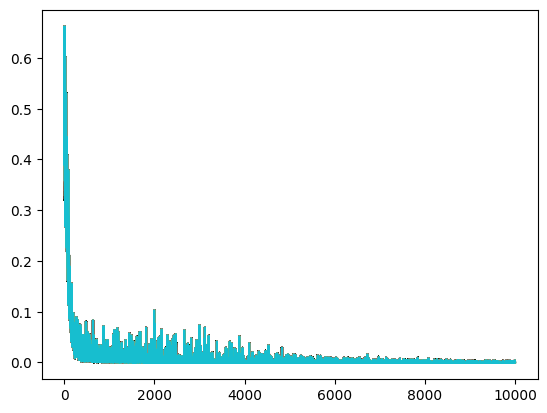

In [ ]:
train(X.float(),Y.float(),n_feature,plot=True)

In [ ]:
# rpm: 1499.52
# motor_power: 6984.88
# torque: 49.186
# outlet_pressure_bar: 4.06
# air_flow: 754.67
# noise_db: 53.41
# outlet_temp: 118.86
# wpump_outlet_press: 2.80
# water_inlet_temp: 83.02
# water_outlet_temp: 96.64
# wpump_power: 222.19
# water_flow: 53.71
# oilpump_power: 300.48
# oil_tank_temp: 46.24
# gaccx: 0.60
# gaccy: 0.35
# gaccz: 3.92
# haccx: 1.10
# haccy: 1.35
# haccz: 3.50
x_in = torch.tensor([1499.52, 6984.88, 49.186, 4.06, 754.67, 53.41, 118.86, 2.80, 83.02, 96.64, 222.19, 53.71, 300.48, 46.24,0.60, 0.35, 3.92, 1.10, 1.35, 3.50])
x_in = (x_in-xmean)/xstd
x_in = x_in.float()
for layer in layers:
  x_in = layer(x_in)
x_in.data

tensor([[0.0004]], grad_fn=<SigmoidBackward0>)